In [90]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [91]:
# 設定亂數種子數值
seed_value= 4
# 1. 設定 Python 環境變數亂數種子
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. 設定 Python 內建亂數生成器亂數種子
import random
random.seed(seed_value)
# 3. 設定 Numpy 亂數種子
import numpy as np
np.random.seed(seed_value)
# 4. 設定 TensorFlow 亂數種子
import tensorflow as tf
tf.random.set_seed(seed_value)

## 1) 載入資料集

In [92]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
X, y = iris.data, iris.target

print('X 資料: ',X.shape)
print('y 資料: ',y.shape)

X 資料:  (150, 4)
y 資料:  (150,)


## 2) 將輸出特徵做one-hot encoding
class 的值有 0,1,2

In [93]:
from tensorflow.keras.utils import to_categorical
y_categorical = to_categorical(y)
y_categorical[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## 3) 切割訓練集與測試集

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.25 , random_state=40)

print('訓練資料: ',X_train.shape)
print('測試資料: ',X_test.shape)

訓練資料:  (112, 4)
測試資料:  (38, 4)


## 2) 建立網路模型

In [95]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.9.1


In [116]:
# 此範例使用 Tensorflow2.0 Sequential API 搭建神經網路。
tf.keras.backend.clear_session() # 清空網路暫存
model = Sequential()
model.add(Dense(8, Activation('relu'), input_dim=X.shape[-1], name='tensor'))
model.add(Dense(16, Activation('relu'), name='dense_1'))
model.add(Dense(3, Activation('softmax'), name='tensor_output'))

In [117]:
model.summary()   # Weights = (4+1)*8+(8+1)*16+(16+1)*3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tensor (Dense)              (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 tensor_output (Dense)       (None, 3)                 51        
                                                                 
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________


In [118]:
# 編譯模型
optim = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

batch_size=1
epochs = 20

# 訓練模型
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.1)


Epoch 1/20
100/100 [==============================] - 0s 2ms/step - loss: 1.6046 - acc: 0.3800 - val_loss: 1.7886 - val_acc: 0.0833
Epoch 2/20
100/100 [==============================] - 0s 866us/step - loss: 1.1338 - acc: 0.3800 - val_loss: 1.3895 - val_acc: 0.0833
Epoch 3/20
100/100 [==============================] - 0s 825us/step - loss: 0.9998 - acc: 0.4800 - val_loss: 1.2050 - val_acc: 0.4167
Epoch 4/20
100/100 [==============================] - 0s 853us/step - loss: 0.9119 - acc: 0.7000 - val_loss: 1.1093 - val_acc: 0.4167
Epoch 5/20
100/100 [==============================] - 0s 835us/step - loss: 0.8306 - acc: 0.7000 - val_loss: 1.0355 - val_acc: 0.4167
Epoch 6/20
100/100 [==============================] - 0s 842us/step - loss: 0.7548 - acc: 0.7000 - val_loss: 0.9758 - val_acc: 0.4167
Epoch 7/20
100/100 [==============================] - 0s 858us/step - loss: 0.6840 - acc: 0.7000 - val_loss: 0.9093 - val_acc: 0.4167
Epoch 8/20
100/100 [==============================] - 0s 854us/s

In [119]:
import tf2onnx
import onnx
# input_signature = [tf.TensorSpec([6.7, 3.1, 4.4, 1.4], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "./model/tf_model.onnx")

2022-08-06 13:09:49.423611: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-08-06 13:09:49.449290: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


In [120]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt

sess = rt.InferenceSession("./model/tf_model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: [[6.7, 3.1, 4.4, 1.4]]})[0]
print(pred_onx.argmax(axis=1))

[1]


In [121]:
input_name

'tensor_input'

In [122]:
label_name

'tensor_output'

## 6) 觀察訓練結果

In [101]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_ = range(1,len(acc)+1)

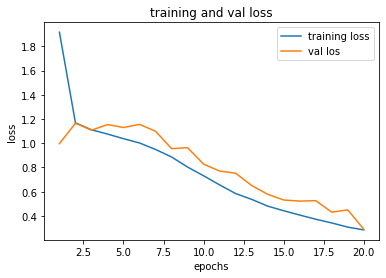

In [102]:
plt.plot(epochs_ , loss , label = 'training loss')
plt.plot(epochs_ , val_loss , label = 'val los')
plt.title('training and val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

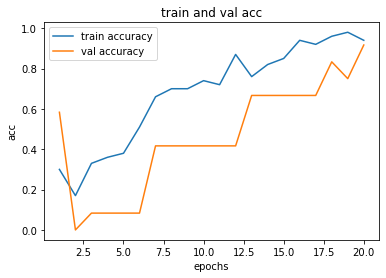

In [103]:
plt.clf()
plt.plot(epochs_ , acc , label='train accuracy')
plt.plot(epochs_ , val_acc , label = 'val accuracy')
plt.title('train and val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

## 測試

In [104]:
from sklearn.metrics import accuracy_score

label=np.argmax(y_test,axis=1)
pred =  np.argmax(model.predict(X_test), axis=1)
print(accuracy_score(label, pred))

2/2 [==============================] - 0s 2ms/step
0.9736842105263158
